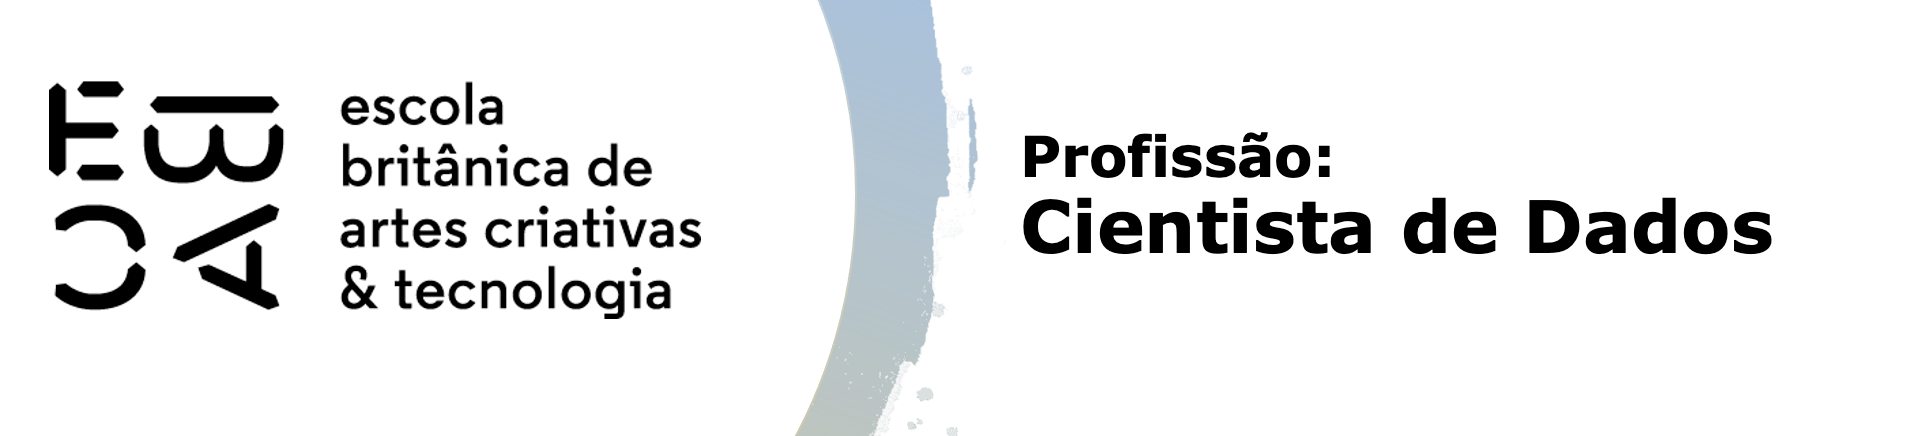

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regressão-III" data-toc-modified-id="Regressão-III-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regressão III</a></span></li><li><span><a href="#Os-dados" data-toc-modified-id="Os-dados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Os dados</a></span></li><li><span><a href="#Inferência-sobre-$\beta$" data-toc-modified-id="Inferência-sobre-$\beta$-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inferência sobre $\beta$</a></span><ul class="toc-item"><li><span><a href="#Intervalo-de-confiança-para-$beta$" data-toc-modified-id="Intervalo-de-confiança-para-$beta$-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Intervalo de confiança para $beta$</a></span></li></ul></li><li><span><a href="#Previsão-para-y" data-toc-modified-id="Previsão-para-y-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Previsão para y</a></span><ul class="toc-item"><li><span><a href="#Incerteza-sobra-a-estimativa-$\hat{y}$" data-toc-modified-id="Incerteza-sobra-a-estimativa-$\hat{y}$-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Incerteza sobra a estimativa $\hat{y}$</a></span></li></ul></li><li><span><a href="#Linearizando-relações-não-lineares" data-toc-modified-id="Linearizando-relações-não-lineares-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Linearizando relações não lineares</a></span><ul class="toc-item"><li><span><a href="#Categorização" data-toc-modified-id="Categorização-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Categorização</a></span></li><li><span><a href="#Transformações-sobre-X" data-toc-modified-id="Transformações-sobre-X-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Transformações sobre X</a></span></li><li><span><a href="#Regressão-segmentada" data-toc-modified-id="Regressão-segmentada-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Regressão segmentada</a></span></li><li><span><a href="#Regressão-segmentada-com-2-ou-mais-nós" data-toc-modified-id="Regressão-segmentada-com-2-ou-mais-nós-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Regressão segmentada com 2 ou mais nós</a></span></li><li><span><a href="#Linearização-com-muitas-observações" data-toc-modified-id="Linearização-com-muitas-observações-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Linearização com muitas observações</a></span></li><li><span><a href="#Lowess" data-toc-modified-id="Lowess-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Lowess</a></span></li></ul></li><li><span><a href="#Referências" data-toc-modified-id="Referências-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

## Regressão III

Neste módulo vamos avaliar aspectos estatísticos da análise de regressão. Vamos resgatar aspectos do teste de hipóteses à luz dos conceitos que vimos nos módulos anteriores de probabilidade e inferência, e vamos discutir as condições necessárias para valer esta inferência.

Objetivos:

- Inferência em regressão
    - Teste de hipóteses
    - Intervalo de confiança
    - Previsões sobre novas observações
    - Previsões sobre a média de y
- Linearizando relações não lineares
    - Transformações
    - Regressão segmentada
    - Lowess

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d # Vamos precisar dessa interpolação

## Os dados

Vamos começar com um exemplo simulado extraído da documentação do statsmodels ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html?highlight=ols))

In [2]:
np.random.seed(1234)

nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

df = pd.DataFrame(X, columns = ['X1', 'X2', 'X3', 'Int'])
df['y'] = y
df['y_true'] = y_true
df.head()

,X1,X2,X3,Int,y,y_true
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590


Text(0.5, 1.0, 'X1 vs Y')

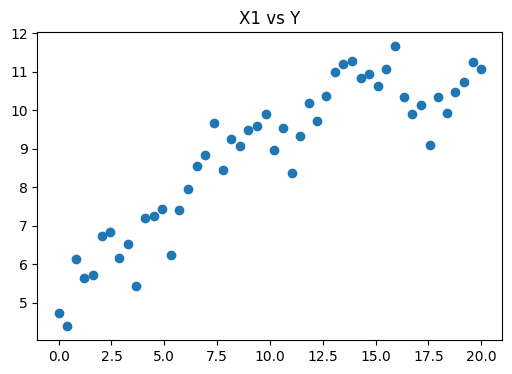

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(x=X[:,0], y=y, label='X1')
ax.set_title('X1 vs Y')

## Inferência sobre $\beta$

Vamos retomar rapidamente a saída da análise de regressão do Statsmodels, agora à luz do que vimos em probabilidade e inferência. Vamos discutir a regressão linear simples (que tem só uma variável) apesar de a regressão múltipla (com mais de uma variável) ser bem mais popular, mas os resutlados que vamos discutir valem também para a regressão múltipla. 

No modelo de regressão tradicional temos que:

$Y \sim \mathcal{N}(\alpha + \beta X,\sigma^2_m)$

Na regressão linear simples, o estimador de mínimos quadrados de $\beta$ pode ser escrito assim:

$$ \hat{\beta} = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sum (X_i - \bar{X})} $$

Esse estimador é basicamente uma função linear dos valores da variável resposta $Y_i's$. Considerando isto tempos os seguintes resultados:

- Os $y_i´s$ possuem distribuição Normal
- Combinações lineares de variáveis com distribuição Normal possuem também distribuição Normal
- Portanto, $\hat{\alpha}$ e $\hat{\beta}$ também possuem distribuição Normal.

Lembre-se que o $\hat{\beta}$ é uma função dos dados, portanto variável aleatória, portanto tem também uma distribuição. Não vamos entrar em detalhes profundos de como deduzir essa distribuição (o que pode ser encontrado em [Neter et. al. (2005)](#neter2005) ou outro livro de modelos lineares). Mas vamos usar esta distribuição, que está mostrada abaixo:

$$\hat{\beta} \sim \mathcal{N}\left(\beta, \sigma^2_\beta \right)$$
com $\sigma^2_\beta = \frac{\sigma^2}{\sum \left(X_i -\bar{X}\right)} $

O que significa que:

$$\frac{\hat{\beta} - \beta}{\sigma_\beta} \sim \mathcal{N}(0,1) $$

e que, substituindo $\sigma$ pelo seu estimador, que é o quadrado médio do resíduo (QME):

$$\frac{\hat{\beta} - \beta}{\hat{\sigma_\beta}} \sim \mathcal{T}(n-2) $$

com $\hat{\sigma_\beta} = \frac{QME}{\sum \left(X_i -\bar{X}\right)} = \frac{\frac{\sum(Y_i - \bar{Y})^2}{n-2}}{\sum \left(X_i -\bar{X}\right)}$

Com isto, podemos testar:

$H_0: \beta = 0$

$H_a: \beta \neq 0$


<br><br>
Logicamente, todos esses cálculos já estão implementados nos pacotes de regressão. O ponto deste texto é para vincular o que fizemos em inferência e o teste que está na análise de regressão, para entendermos o conceito: Se formularmos uma hipótese nula $H_0: \beta = 0$, podemos testá-la exatamente da mesma forma que fizemos em inferência. Mas o que significa $\beta = 0$? Significa que a variável $X$ correspondente não tem relação linear com Y - o que torna esse teste bastante interessante, por isso é bem padrão que esteja na maioria dos pacotes.

Vamos rodar na nossa base de exemplo.

In [4]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1',data=df).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     191.5
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.25e-18
Time:                        16:41:24   Log-Likelihood:                -64.035
No. Observations:                  50   AIC:                             132.1
Df Residuals:                      48   BIC:                             135.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9090      0.248     23.857      0.000       5.411       6.407
X1             0.2953      0.021     13.839      0.000       0.252       0.338
==============================================================================
Omnibus:                        3.070   Durbin-Watson:                   0.711
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.023
Skew:                          -0.285   Prob(JB):                        0.364
Kurtosis:                       2.197   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
.2953/.021

14.061904761904762

Observe que todas as informações do modelo estão no objeto ```res```, incluindo os próprios parâmetros.

In [6]:
res.params

Intercept    5.908971
X1           0.295330
dtype: float64

Eventualmente pode ser interessante também acessar cada tabela do resumo obtido com o método ```res.summary()``` separadamente.

In [7]:
resumo = res.summary()
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


### Intervalo de confiança para $beta$

O intervalo de confiança é uma estimativa para o parâmetro (o $\beta$ no caso) que contempla a sua incerteza amostral. O intervalo de confiança está relacionado com o teste de sifnigicância. A confiança é denotada pela letra grega $\gamma$, que é o complementar da significância $\alpha$. Ou seja, $\gamma = 1 - \alpha$.

De uma forma bem simples, estando todas as suposições do modelo suficientemente atendidas, podemos dizer com $\gamma\%$ de confiança que o verdadeiro parâmetro está dentro do intevalo.

**Antes de coletar os dados**, podemos dizer que temos $\gamma\%$ de probavilidade de o verdadeiro parâmetro $\beta$ cair dentro do intervalo - ou melhor, o intervalo é que aparece com o parâmetro dentro, pois o parâmetro é uma constante desconhecida, e o intervalo é que é aleatório.

**Após coletar os dados** o intervalo está dado, e o parâmetro é uma constante desconhecida. Dito isto, conceitualmente não podemos falar mais em probabilidade, por isso falamos em confiança. Por isso temos $\gamma\%$ de confiança em afirmar que o parâmetro está dentro do intervalo. Por exemplo, com o clássico 95% de confiança, esperamos que a cada 20 afirmações dessas, estejamos errados em uma.

A construção do intervalo de confiança é a seguinte: obtemos a amplitude do intervalo a partir da densidade do estimador, de modo que a probabilidade de o estimador estar neste intervalo seja $\gamma\%$ (95% por exemplo). Então construímos um intervalo com esta amplitude, centrado no valor estimado do parâmetro.

In [8]:
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


**Dica de formatação**

Uma dica interessante é que podemos selecionar partes específicas desse output, transformar em objeto do Pandas e formatar com os conhecimentos que já temos de pandas, por exemplo o ```.style()```. Abaixo vamos fazer isso passo a passo.

A indexação básica seleciona a tabela desejada. No caso ```resumo.tables[1]``` vai pegar a tabela com os parâmetros e os testes.

In [9]:
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


A forma mais fácil de transformar essa tabela em Data Frame (que eu conheço pelo menos) é usar o ```.to_html``` para convertê-la em HTML, em seguida usar a função ```pd.read_html()``` do pandas. Repare que essa função é feita para ler uma página de internet e encontrar as tabelas (no plural mesmo, mais de uma), e retornar uma lista com todas as tabelas da página. Por isso vamos precisar da indexação final indicando que queremos a primeira tabela (mesmo sendo a única).

Agora vamos usar o ```.style``` do pandas para realçar os *p-values* menores que 5%, colocar vírgula como separador de decimal e 4 casas decimais.

In [10]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        right=.05
        , axis=1
        , props='color:red'
        , subset='P>|t|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3505941048.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"5,9090","0,2480","23,8570","0,0000","5,4110","6,4070"
X1,"0,2953","0,0210","13,8390","0,0000","0,2520","0,3380"


## Previsão para y

É muito comum precisarmos fazer previsão para y, e já fizemos isso diversas vezes. A diferença no que vamos fazer agora é que vamos fazer uma previsão **pontual** (a que já estamos acostumados) e uma previsão **por intervalo** que leva em conta, em alguma medida, o erro amostral da nossa estimativa.

**Recapitulando**

- Definimos a variável resposta ```y```
- Definimos as varáveis explicativas (apenas ```X1``` no caso)
- Trouxemos o objeto ```smf.ols()``` do statsmodels, indicando o modelo e os dados
- Aplicamos o método ```fit()``` para "treinar" o modelo
- No script abaixo, guardamos tudo isso na variável ```res```
- Em seguida podemos aplicar, por exemplo, o método ```res.predict``` para fazer previsões

In [11]:
res = smf.ols('y ~ X1',data=df).fit()

res.predict(exog = df.tail(3))

47    11.574489
48    11.695032
49    11.815575
dtype: float64

### Incerteza sobra a estimativa $\hat{y}$

O modelo de regressão acima é formulado da seguinte maneira:

$$ y_i = \alpha + \beta_1.X_{1, i} + \epsilon{i} $$

com:

- $X_{1, i}$ são os valores da variável $X_1$ para cada um dos indivíduos $i$, com $i=1, 2,... n$. Uma vez observados, são considerados constantes. 
- $\alpha$ sendo uma constante (não é aleatória), e pode ser interpretada como o valor de $Y$ quando $X_1=0$ (mesmo que esta interpretação seja meramente teórica)
- $\beta_1$ é uma constante, e pode ser interpretada como "o aumento em $y$ para cada unidade incrementada em $X_1$ 
- $\epsilon_i$ é o resíduo, ou seja, a diferença entre o verdadeiro valor de $Y_i$ e o seu valor esperado dado pelo modelo $E(Y_i) = \alpha + \beta X_i$. Tem distribuição aleatória Normal, com média zero e uma variância do modelo $\sigma^2_m$.

<div align="center">
<img src="./img/image.png" width="300"/>
</div>

**Incertezas**

Tenha em mente que com esta estrutura do modelo de regressão, o valor de $y_j$ de uma nova observação *j* (não pertencente à amostra de treino), que é o que queremos prever, tem essa distribuição:

$$ y_j \sim N(\alpha + \beta x_1, \sigma^2_m) $$

De modo que se conhecermos $\alpha$ e $\beta$ (os parâmetros da regressão) mais o $\sigma^2_m$ (variância dos resíduos), podemos fazer toda a inferência convencional com a própria distribuição Normal sobre o $Y_j$.

No entanto, se queremos prever a média para uma nova observação, levando em conta o seu *erro padrão* (ou o "erro amostral"), vale ter em mente que essa previsão tem uma incerteza natural por conta da própria variância dos resíduos $\sigma^2_m$.

Vale também ressaltar que quando obtemos as estimativas dos parâmetros baseadas nos dados, os $\hat{\alpha}$ e $\hat{\beta}$, temos incerteza na estimativa dessas quantidades também.

Dessa forma, o erro amostral na previsão de uma nova observação vai depender do erro padrão de $\hat{\alpha} + \hat{\beta}x_i$ e vai depender também do $\hat{\sigma}^2_m$.

**IC da média e IC de uma nova observação**

Repare também que, quando estamos fazendo inferência sobre a média de $\hat{y}_i$, a parte que depende de $\sigma^2_m$ não é mais relevante, de modo que o erro padrão vai ser típicamente bem menor. Em geral os pacotes que realizam esse tipo de previsão possuem as duas formas disponíveis, no Python não é diferente - só precisamos saber qual queremos e a diferença entre elas.

**Como fazemos a previsão no Python?**

In [12]:
IC = res.get_prediction(exog = df.tail(3))
IC.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.574489,0.232837,11.106338,12.042639,9.727035,13.421942
1,11.695032,0.240215,11.212046,12.178017,9.843763,13.546300
2,11.815575,0.247680,11.317580,12.313569,9.960334,13.670815


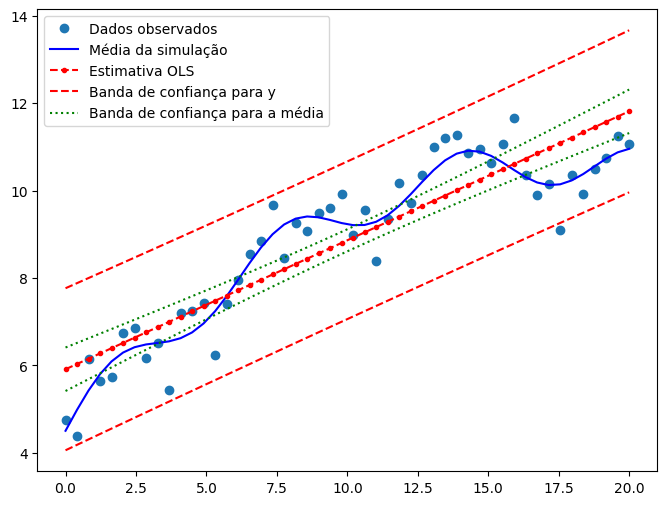

In [13]:
def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.X1, data.y, "o", label="Dados observados")
    ax.plot(data.X1, data.y_true, "b-", label="Média da simulação")
    ax.plot(data.X1, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.X1, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.X1, iv_l, "r--")
    ax.plot(data.X1, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, "g:")
    ax.legend(loc="best")
    plt.show

esp_vs_obs()

## Linearizando relações não lineares

A grande maioria dos problemas envolve dados bem representados por modelos lineares, **embora as relações de dependência possam ser não lineares**. Sim, é isso mesmo, através de transformações, muitas vezes simples simples (não lineares, é claro), podemos linearizar de forma bastante suficiente as relações entre as variáveis explicativas e a resposta.

Lembre-se:
- "Todo modelo está errado, mas alguns são úteis" como dizia George E. P. Box.


Vamos estudar agora formas de procurar linearizar relações não lineares. Vamos ver aqui as seguintes abordagens:

- **Categorização:** <br>
    Uma estratégia bem antiga e funcional consiste em transformar uma variável contínua em categorizada, modelando com *dummies* para cada categoria. Em crédito, essa estratégia é realizada desde os anos 70 (talvez antes) e até hoje é utilizada porque funciona. A vantagem da estratégia está no pragmatismo e simplicidade.

- **Aplicar transformações convencionais em X:**<br>
    Consiste em aplicar transformações como logaritmo, polinômios etc e buscar uma relação mais linear da variável explicativa com a resposta.

- **Regressão segmentada:**<br>
    Uma técnica bem interessante que consiste em definir um ponto de alteração da inclinação da reta de regressão.
    
- **Lowess:**<br>
    Uma técnica não paramêtrica que suavisa uma relação entre duas variáveis.

<div align="center">
<img src="./img/image_2.png" width="400"/>
</div>


In [14]:
def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.X1, data.y, "o", label="Dados observados")
    ax.plot(data.X1, data.y_true, "b-", label="Média da simulação")
    ax.plot(data.X1, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.X1, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.X1, iv_l, "r--")
    ax.plot(data.X1, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, "g:")
    ax.legend(loc="best")
    plt.show

R-quadrado: 79.96%


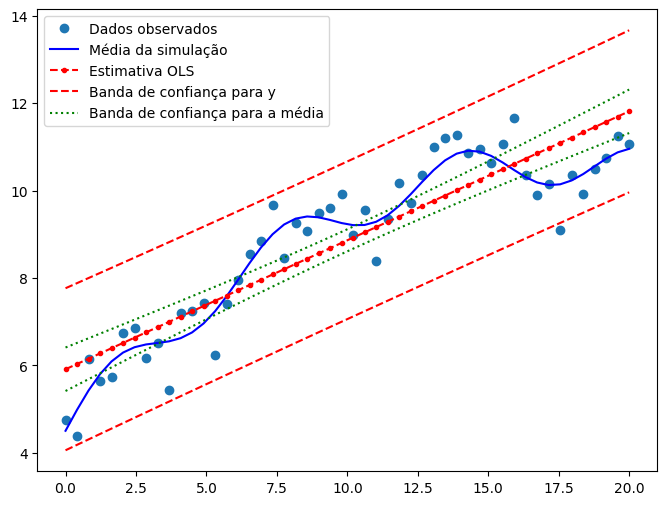

In [15]:
res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1',data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs();

### Categorização

Uma ideia muito simples: categorizar a variável X e inserir as *dummies* de cada categoria. A estratégia tradicional consiste no seguinte:

1. Categorizar a variável por quantis (o ```pd.qcut()``` faz isso) em um número arbitrário, digamos, 10. Podemos usar mais grupos conforme o tamanho da amostra for maior.
2. Avaliar a média da variável resposta em cada grupo.
3. Agrupar os grupos que possuem a média da variável resposta muito parecida.

Vamos ver como podemos fazer isso no Pandas:

C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\2085897093.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_med['y'] = df.groupby('X1_cat')['y'].mean()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\2085897093.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat')['y'].sem()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\2085897093.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and si

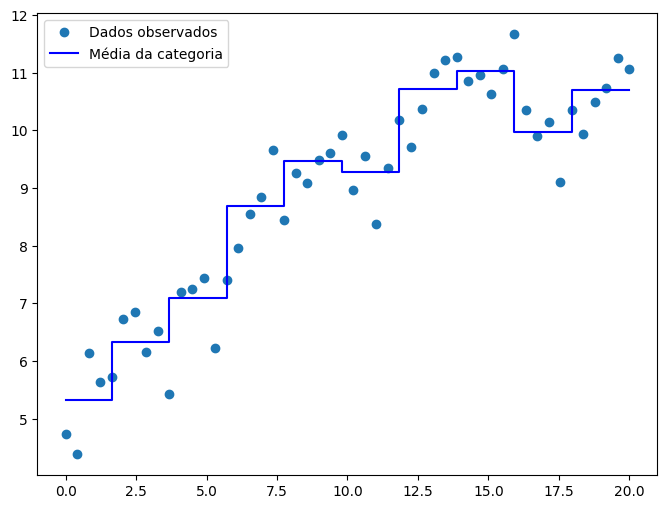

In [16]:
df['X1_cat'], quebras = pd.qcut(df.X1, 10, duplicates='drop', retbins=True)

y_med = pd.DataFrame()
y_med['y'] = df.groupby('X1_cat')['y'].mean()
y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat')['y'].sem()
y_med['y_max'] = y_med.y + 2*df.groupby('X1_cat')['y'].sem()

y_med.rename(columns={'y':'y_med'}, inplace=True)
# y_med.columns = []

tab = df.merge(y_med, on='X1_cat', how='left')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tab.X1, tab.y, "o", label="Dados observados", alpha=1)
ax.step(tab.X1, tab.y_med, "b-", label="Média da categoria", alpha=1)
ax.legend()
plt.show()

In [17]:
quebras

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

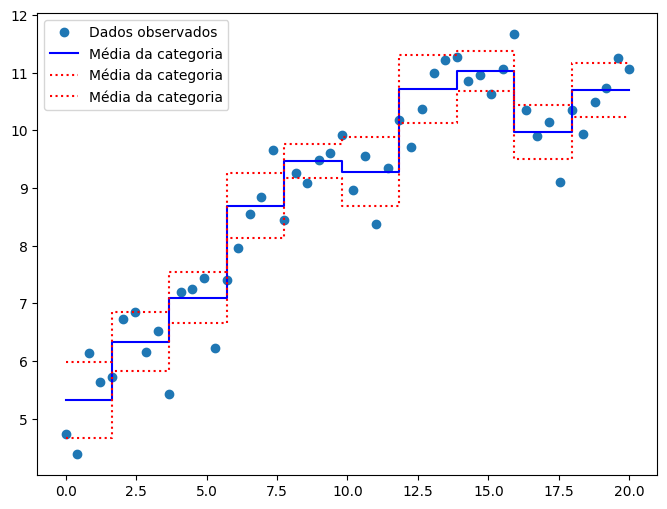

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tab.X1, tab.y, "o", label="Dados observados", alpha=1)
ax.step(tab.X1, tab.y_med, "b-", label="Média da categoria", alpha=1)
ax.step(tab.X1, tab.y_min, "r:", label="Média da categoria", alpha=1)
ax.step(tab.X1, tab.y_max, "r:", label="Média da categoria", alpha=1)
ax.legend()
plt.show()

In [19]:
quebras

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3879987911.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_med['y'] = df.groupby('X1_cat')['y'].mean()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3879987911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat')['y'].sem()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3879987911.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and si

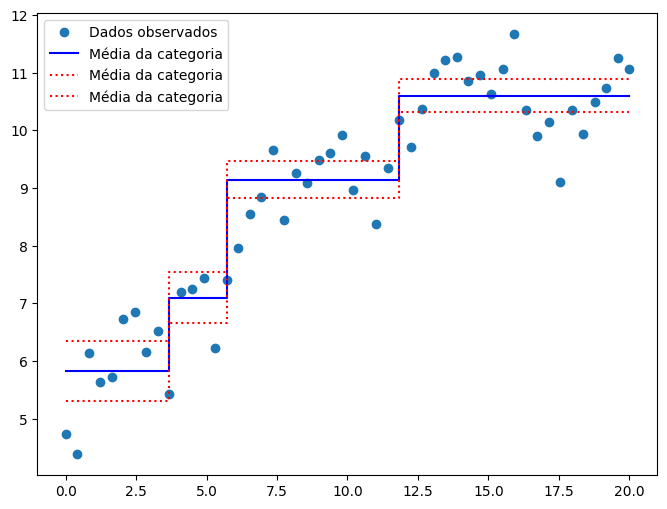

In [20]:
quebras2 = [ -np.inf,  4.,  6.,  12., 20.]

df['X1_cat'] = pd.cut(df['X1'], quebras2)

y_med = pd.DataFrame()
y_med['y'] = df.groupby('X1_cat')['y'].mean()
y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat')['y'].sem()
y_med['y_max'] = y_med.y + 2*df.groupby('X1_cat')['y'].sem()

y_med.rename(columns={'y':'y_med'}, inplace=True)
# y_med.columns = []

tab = df.merge(y_med, on='X1_cat', how='left')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tab.X1, tab.y, "o", label="Dados observados", alpha=1)
ax.step(tab.X1, tab.y_med, "b-", label="Média da categoria", alpha=1)
ax.step(tab.X1, tab.y_min, "r:", label="Média da categoria", alpha=1)
ax.step(tab.X1, tab.y_max, "r:", label="Média da categoria", alpha=1)
ax.legend()
plt.show()

In [21]:
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]"
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]"
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]"
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]"
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]"


R-quadrado: 89.43%


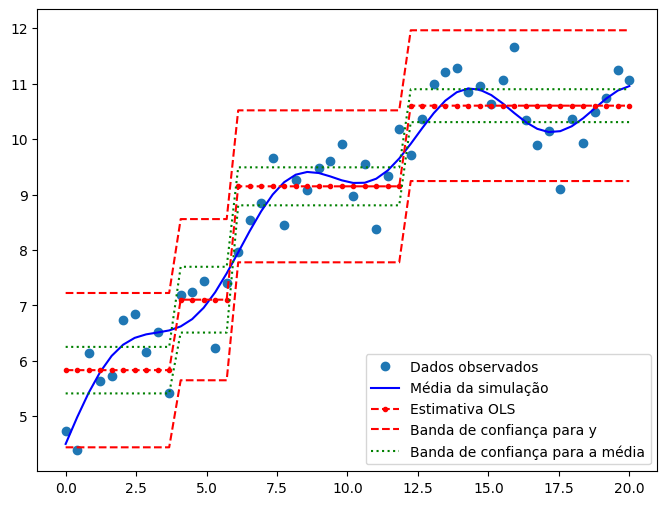

In [22]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1_cat',data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

### Transformações sobre X

Uma abordagem bastante prática, popular e que traz interpretabilidade conveniente em muitos casos é utilizar uma transformação de X, como o logaritmo, expoente ou qualquer outra função que seja conveniente.

Nesse ponto, o pacote formula do statsmodels é muito prático. Vamos ver:

R-quadrado: 79.96%


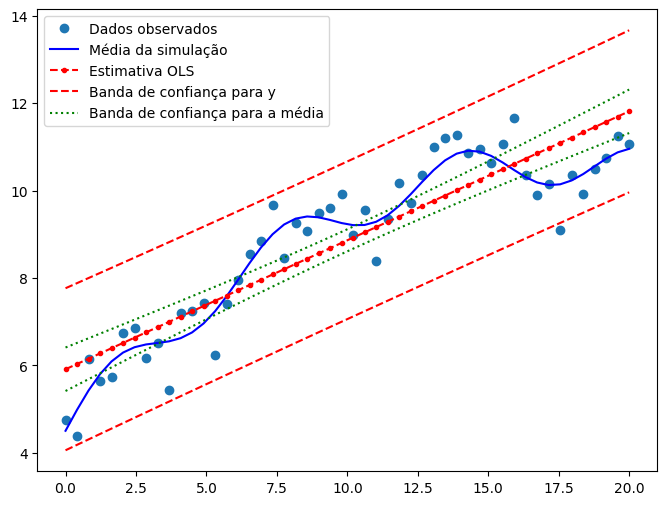

In [23]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1',data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

R-quadrado: 87.25%


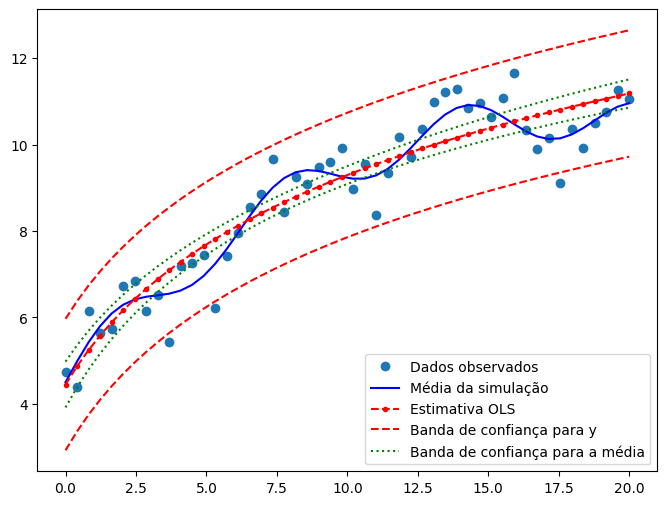

In [24]:
# res = sm.OLS(y, x).fit()
# df['log_x1'] = np.log(df.X1+1)


res = smf.ols('y ~ I(np.log(X1+3))',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

R-quadrado: 89.19%


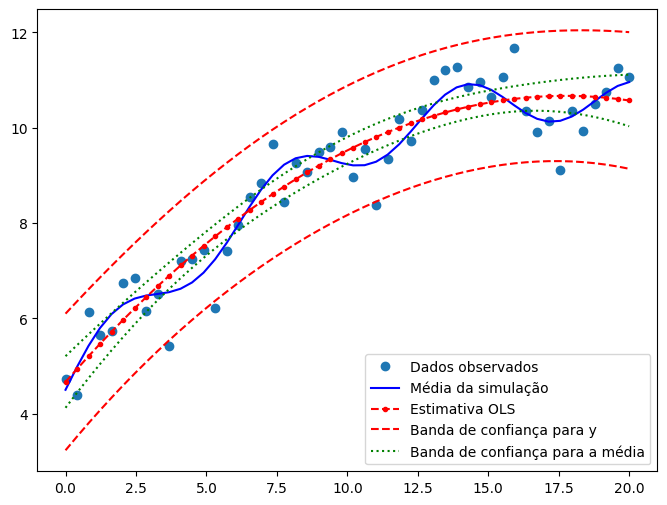

In [25]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1 + I(X1**2)',data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

R-quadrado: 94.11%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     244.8
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.79e-28
Time:                        16:41:37   Log-Likelihood:                -33.436
No. Observations:                  50   AIC:                             74.87
Df Residuals:                      46   BIC:                             82.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3999      0.205     21.433      0.000       3.987       4.813
X1                0.7298      0.047     15.454      0.000       0.635       0.825
I(X1 ** 2)       -0.0212      0.002     -9.342      0.000      -0.026      -0.017
I(np.sin(X1))     0.6303      0.102      6.195      0.000       0.425       0.835
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.577
Skew:                          -0.263   Prob(JB):                        0.749
Kurtosis:                       2.972   Cond. No.                         551.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

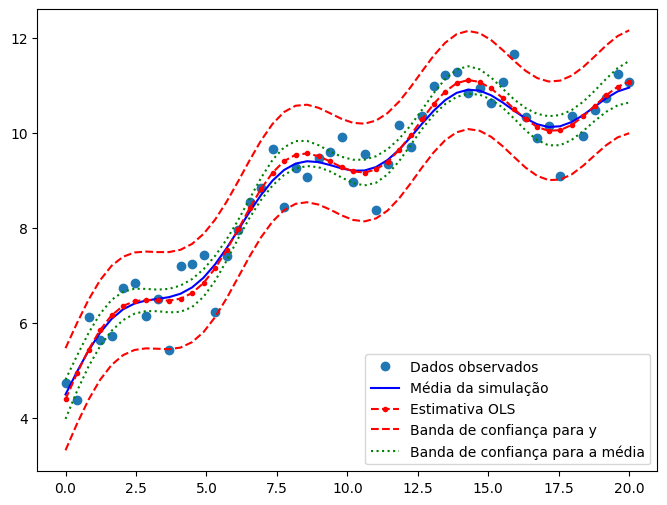

In [26]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1 + I(X1**2) + I(np.sin(X1))',data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

res.summary()

### Regressão segmentada

Uma abordagem interessante para encontrar uma função de linearização de variáveis é a regressão segmentada. Com ela indicamos uma inclinação da reta para valores de $X$ menores que um certo valor de corte $C_0$, e uma outra inclinação para valores de $X$ maiores que esse valor de corte $C_0$.

<div align="center">
<img src="./img/image_3.png" width="300"/>
</div>

Para isto, criamos duas variáveis auxiliares $X_a$ e $X_b$ da seguinte forma:

<div align="center">
<img src="./img/image_4.png" />
</div>


De modo que o modelo fica assim:

$Y = \alpha + \beta_1*X_a + \beta_2*X_b + \epsilon $

Repare que:
- Quando $X_a < C_0$ $X_b$ vai valer zero.
- Quando $X_a = C_0$ $X_b$ vai valer zero, e $X_a = C_0$.
- Quando $X_a > C_0$ $X_b$ vai valer $X - C_0$ e $X_a = C_0$.


R-quadrado: 89.05%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     191.1
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           2.67e-23
Time:                        16:41:39   Log-Likelihood:                -48.925
No. Observations:                  50   AIC:                             103.9
Df Residuals:                      47   BIC:                             109.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1060      0.225     22.664      0.000       4.653       5.559
X1_1           0.4453      0.029     15.450      0.000       0.387       0.503
X1_2           0.0226      0.046      0.487      0.628      -0.071       0.116
==============================================================================
Omnibus:                        3.319   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.786
Skew:                          -0.578   Prob(JB):                        0.248
Kurtosis:                       3.006   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

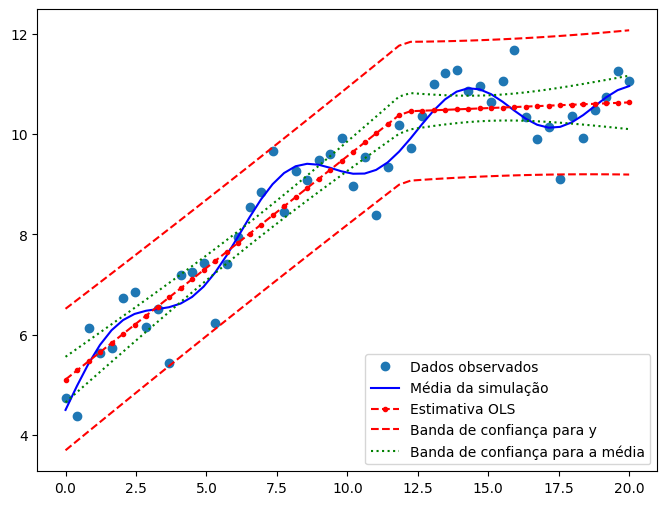

In [27]:
C1=12

df['X1_1'] = (df.X1<=C1)*df.X1 + (df.X1>C1)*C1
df['X1_2'] = (df.X1<=C1)*0 + (df.X1>C1)*(df.X1-C1)

# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1_1 + X1_2',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')
esp_vs_obs()
res.summary()

R-quadrado: 88.99%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     388.1
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           1.21e-24
Time:                        16:41:41   Log-Likelihood:                -49.051
No. Observations:                  50   AIC:                             102.1
Df Residuals:                      48   BIC:                             105.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0738      0.214     23.746      0.000       4.644       5.503
X1_1           0.4536      0.023     19.701      0.000       0.407       0.500
==============================================================================
Omnibus:                        3.561   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.972
Skew:                          -0.597   Prob(JB):                        0.226
Kurtosis:                       3.044   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

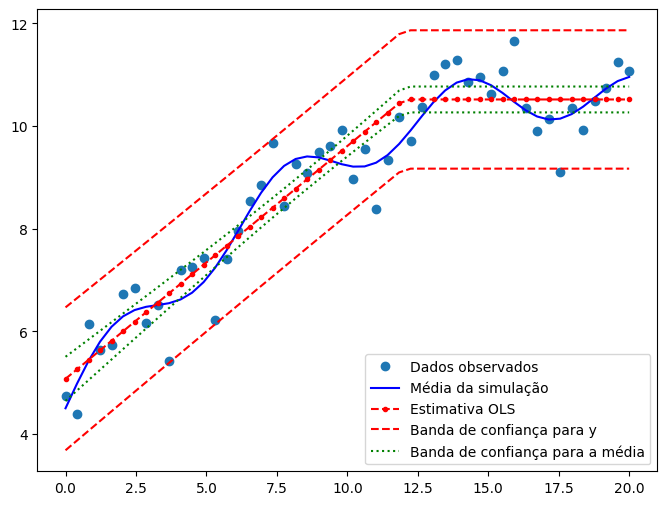

In [28]:
# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1_1',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')
esp_vs_obs()
res.summary()

### Regressão segmentada com 2 ou mais nós

Com três mudanças de inclinação, podemos especificar a regressão segmentada através dessas variáveis auxiliares conforme indicado abaixo. Para aumentar o número de 'nós' (ou mudanças de inclinação), basta definir mais pontos ($C_1, C_2, ... C_n$) e seguir a lógica abaixo.

<div>
<img src="./img/image_5.png" width="300"/>
</div>

Graficamente temos as variáveis definidas assim:

<div align="center">
<img src="./img/image_6.png" width="300"/>
</div>

R-quadrado: 90.21%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     141.2
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           3.24e-23
Time:                        16:41:44   Log-Likelihood:                -46.134
No. Observations:                  50   AIC:                             100.3
Df Residuals:                      46   BIC:                             107.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8987      0.257     19.063      0.000       4.381       5.416
X1_1           0.5068      0.048     10.641      0.000       0.411       0.603
X1_2           0.2701      0.049      5.528      0.000       0.172       0.369
X1_3          -0.0932      0.087     -1.067      0.292      -0.269       0.083
==============================================================================
Omnibus:                        3.887   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.231
Skew:                          -0.621   Prob(JB):                        0.199
Kurtosis:                       3.092   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

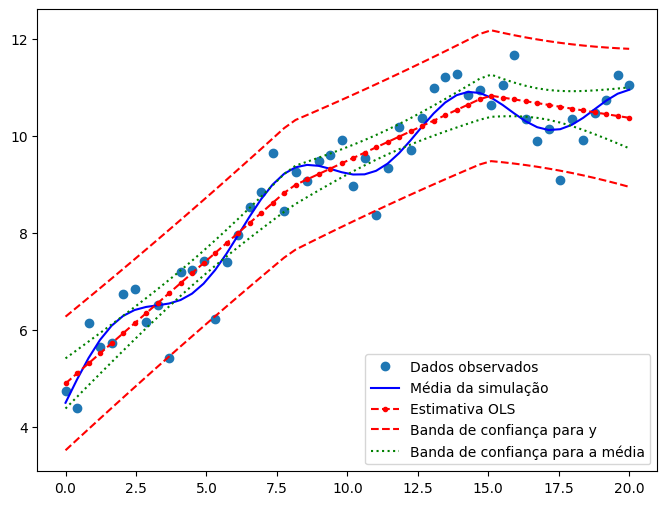

In [29]:
C1 = 8
C2 = 15

df['X1_1'] = (df.X1<=C1)*df.X1 + (df.X1>C1)*C1
df['X1_2'] = (df.X1<=C1)*0 + ((df.X1>C1) & (df.X1<=C2))*(df.X1-C1) + (df.X1>C2)*(C2-C1)
df['X1_3'] = (df.X1<=C2)*0 + (df.X1>C2)*(df.X1-C2)

# res = sm.OLS(y, x).fit()
res = smf.ols('y ~ X1_1 + X1_2 + X1_3',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()
res.summary()

R-quadrado: 89.96%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     210.7
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           3.44e-24
Time:                        16:41:46   Log-Likelihood:                -46.745
No. Observations:                  50   AIC:                             99.49
Df Residuals:                      47   BIC:                             105.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8771      0.257     19.010      0.000       4.361       5.393
X1_1           0.5153      0.047     10.959      0.000       0.421       0.610
X1_2           0.2386      0.039      6.127      0.000       0.160       0.317
==============================================================================
Omnibus:                        3.821   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.130
Skew:                          -0.610   Prob(JB):                        0.209
Kurtosis:                       3.118   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

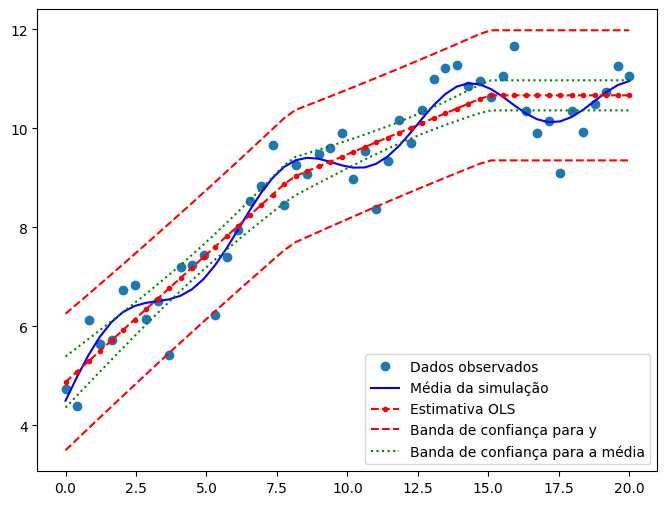

In [30]:
res = smf.ols('y ~ X1_1 + X1_2',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()
res.summary()

### Linearização com muitas observações

Se tivermos muitos pontos, o gráfico de dispersão fica tipicamente pouco útil em dados reais. Assim, uma maneira de se conduzir a linearização da variável 

In [31]:
nsample2 = 50_000
sig = 0.5
x2 = np.linspace(0, 20, nsample2)
X2 = np.column_stack((x2, np.sin(x2), (x2 - 5) ** 2, np.ones(nsample2)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true2 = np.dot(X2, beta)
y2 = y_true2 + sig * np.random.normal(size=nsample2)

df2 = pd.DataFrame(X2, columns = ['X1', 'X2', 'X3', 'Int'])
df2['y'] = y2
df2['y_true'] = y_true2
df2.head()

,X1,X2,X3,Int,y,y_true
0,0.0000,0.0000,25.000000,1.0,4.920504,4.50000
1,0.0004,0.0004,24.996000,1.0,3.777575,4.50048
2,0.0008,0.0008,24.992000,1.0,3.799973,4.50096
3,0.0012,0.0012,24.988001,1.0,4.450981,4.50144
4,0.0016,0.0016,24.984002,1.0,4.227799,4.50192


In [32]:
def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.X1, data.y, "o", label="Dados observados", alpha=1)
    ax.plot(data.X1, data.y_true, "b-", label="Média da simulação")
    ax.plot(data.X1, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.X1, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.X1, iv_l, "r--")
    ax.plot(data.X1, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, "g:")
    ax.legend(loc="best")
    plt.show

R-quadrado: 86.80%


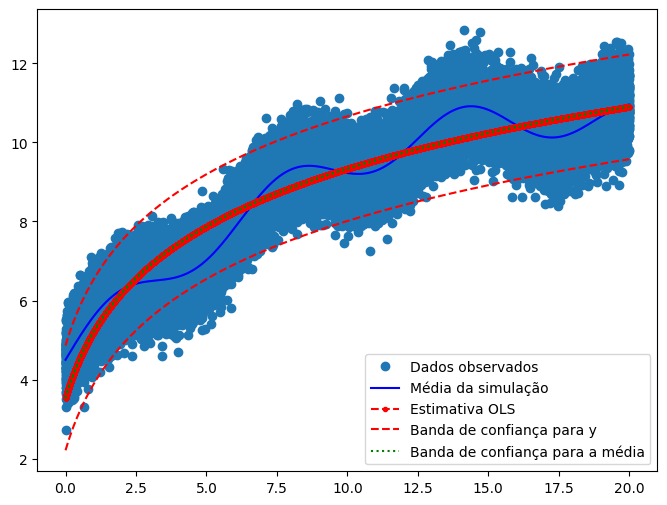

In [33]:
res = smf.ols('y ~ I(np.log(X1+1))',data=df2).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(data=df2);

C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3771029151.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df2.groupby(grupos)['y'].describe()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3771029151.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab['X1'] = df2.groupby(grupos)['X1'].mean()
C:\Users\gfsil\AppData\Local\Temp\ipykernel_20012\3771029151.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


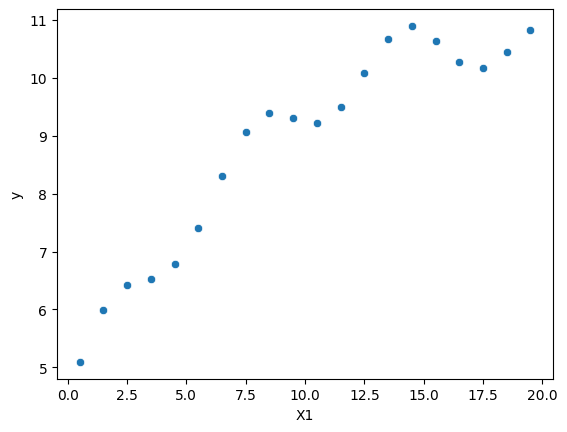

In [34]:
grupos = pd.qcut(df2.X1, 20)

tab = df2.groupby(grupos)['y'].describe()
tab['X1'] = df2.groupby(grupos)['X1'].mean()
tab['y_true'] = df2.groupby(grupos)['y_true'].mean()

tab.rename(columns={'mean':'y'}, inplace=True)

sns.scatterplot(data=tab, x = 'X1', y = 'y')
plt.show()

In [35]:
tab.head()

,count,y,std,min,25%,50%,75%,max,X1,y_true
X1,,,,,,,,,,
"(-0.001, 1.0]",2500.0,5.092981,0.595900,2.733119,4.695619,5.077063,5.500055,7.111472,0.49981,5.072973
"(1.0, 2.0]",2500.0,5.987564,0.539430,4.188848,5.630805,5.980754,6.377696,7.714947,1.49983,5.981442
"(2.0, 3.0]",2500.0,6.416624,0.501132,4.588343,6.085020,6.411811,6.757337,7.918422,2.49985,6.410223
"(3.0, 4.0]",2500.0,6.533632,0.503573,4.595000,6.205119,6.534925,6.868388,8.140730,3.49987,6.535145
"(4.0, 5.0]",2500.0,6.780106,0.518744,4.694232,6.433313,6.789383,7.139632,8.766069,4.49989,6.774635


R-quadrado: 94.81%


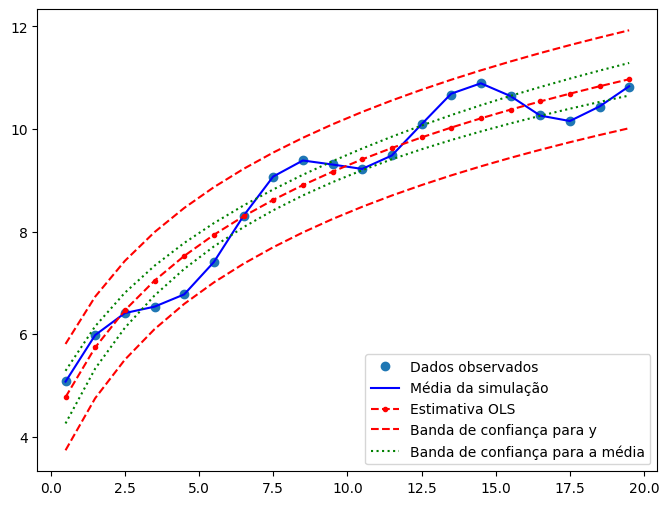

In [36]:
res = smf.ols('y ~ I(np.log(X1+2))',data=tab).fit()
print(f'R-quadrado: {res.rsquared:.2%}')
esp_vs_obs(data=tab)

R-quadrado: 88.79%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     121.4
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           7.22e-22
Time:                        16:41:53   Log-Likelihood:                -49.515
No. Observations:                  50   AIC:                             107.0
Df Residuals:                      46   BIC:                             114.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6967      0.518      9.076      0.000       3.655       5.738
X1_1           0.7195      0.410      1.756      0.086      -0.105       1.544
X1_2           0.4771      0.044     10.851      0.000       0.389       0.566
X1_3           0.1040      0.037      2.792      0.008       0.029       0.179
==============================================================================
Omnibus:                        2.418   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                1.829
Skew:                          -0.467   Prob(JB):                        0.401
Kurtosis:                       3.084   Cond. No.                         52.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

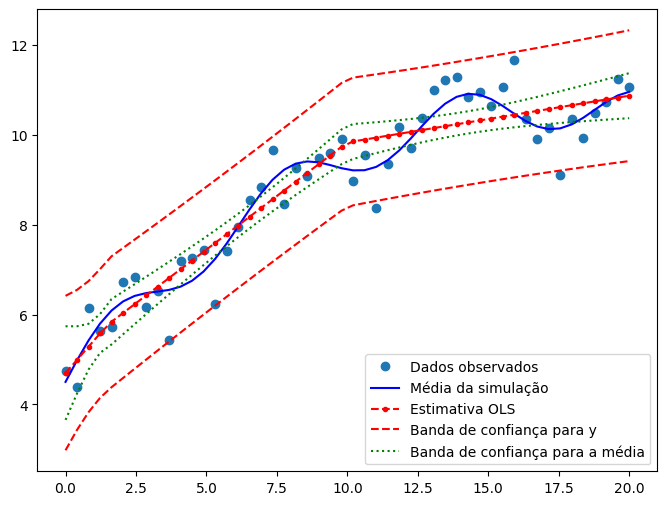

In [37]:
C1 = 1.5
C2 = 10

df['X1_1'] = (df.X1<=C1)*df.X1 + (df.X1>C1)*C1
df['X1_2'] = (df.X1<=C1)*0 + ((df.X1>C1) & (df.X1<=C2))*(df.X1-C1) + (df.X1>C2)*(C2-C1)
df['X1_3'] = (df.X1<=C2)*0 + (df.X1>C2)*(df.X1-C2)

res = smf.ols('y ~ X1_1 + X1_2 + X1_3',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()
res.summary()

### Lowess

Lowess significa "*Locally Weighted Scatterplot Smoothing*" (ou suavização de gráfico de dispersão localmente ponderada). É um método não-paramétrico, isto é, não assume distribuição de probabilidade específica para os dados, e encontra uma curva suave para Y dado cada valor de X. Essa função Y(X) "dá mais importância" para pontos próximos do X em questão, diminuindo rapidamente a importância para pontos mais longe.

Vamos ver o método de uma forma mais prática, mas para quem se interessar na matemática dele, estamos deixando alguns artigos nas referências mais abaixo.

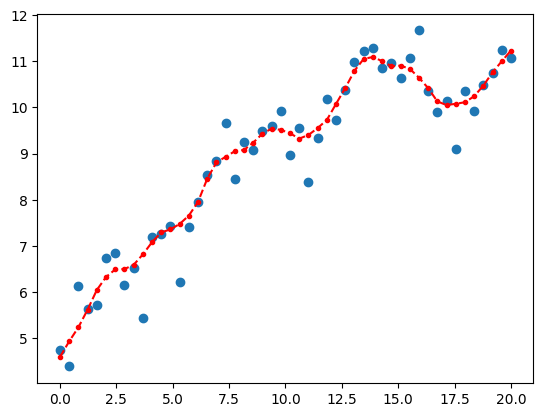

In [38]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=1/8)

# Valores de Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Gráfico
fig, ax = plt.subplots()

ax.plot(df.X1, df.y, "o", label="Dados observados", alpha=1)
ax.plot(df.X1, lowess_y, "r--.", label="Lowess")
plt.show()

In [39]:
# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df['X1_lowess'] = f(df.X1)
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,X1_1,X1_2,X1_3,X1_lowess
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000,0.000000,0.0,4.594138
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.408163,0.000000,0.0,4.930406
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.816327,0.000000,0.0,5.235521
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",1.224490,0.000000,0.0,5.617355
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",1.500000,0.132653,0.0,6.042604


R-quadrado: 94.50%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     825.2
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           6.82e-32
Time:                        16:41:55   Log-Likelihood:                -31.696
No. Observations:                  50   AIC:                             67.39
Df Residuals:                      48   BIC:                             71.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2225      0.323     -0.689      0.494      -0.872       0.427
X1_lowess      1.0194      0.035     28.726      0.000       0.948       1.091
==============================================================================
Omnibus:                        7.084   Durbin-Watson:                   2.405
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.834
Skew:                          -0.584   Prob(JB):                       0.0328
Kurtosis:                       4.385   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

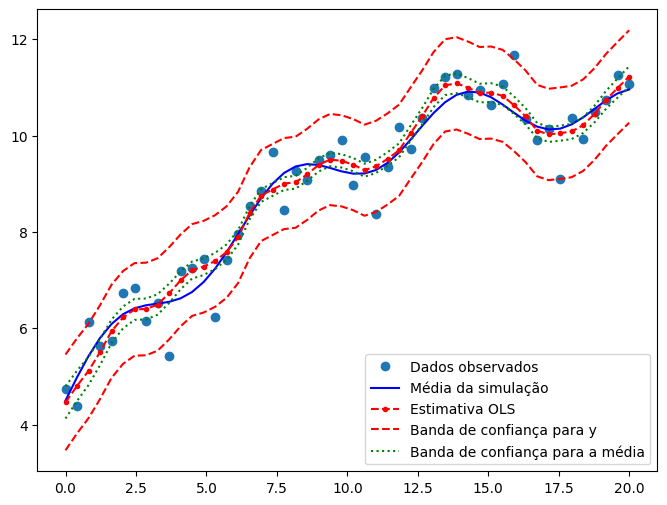

In [40]:
res = smf.ols('y ~ X1_lowess',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

res.summary()

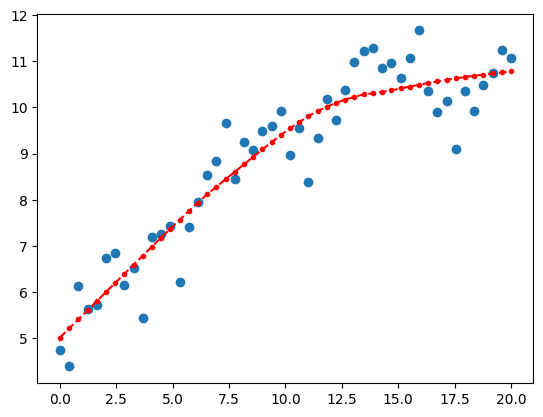

In [41]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=2/3)

# Valores de Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Gráfico
fig, ax = plt.subplots()

ax.plot(df.X1, df.y, "o", label="Dados observados", alpha=1)
ax.plot(df.X1, lowess_y, "r--.", label="Lowess")
plt.show()

In [42]:
# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df['X1_lowess'] = f(df.X1)
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,X1_1,X1_2,X1_3,X1_lowess
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000,0.000000,0.0,5.013091
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.408163,0.000000,0.0,5.210501
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.816327,0.000000,0.0,5.407710
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",1.224490,0.000000,0.0,5.604841
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",1.500000,0.132653,0.0,5.801965


R-quadrado: 89.09%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     392.1
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           9.73e-25
Time:                        16:41:59   Log-Likelihood:                -48.825
No. Observations:                  50   AIC:                             101.7
Df Residuals:                      48   BIC:                             105.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1146      0.463     -0.248      0.806      -1.045       0.816
X1_lowess      1.0168      0.051     19.801      0.000       0.914       1.120
==============================================================================
Omnibus:                        3.269   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.689
Skew:                          -0.568   Prob(JB):                        0.261
Kurtosis:                       3.041   Cond. No.                         45.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

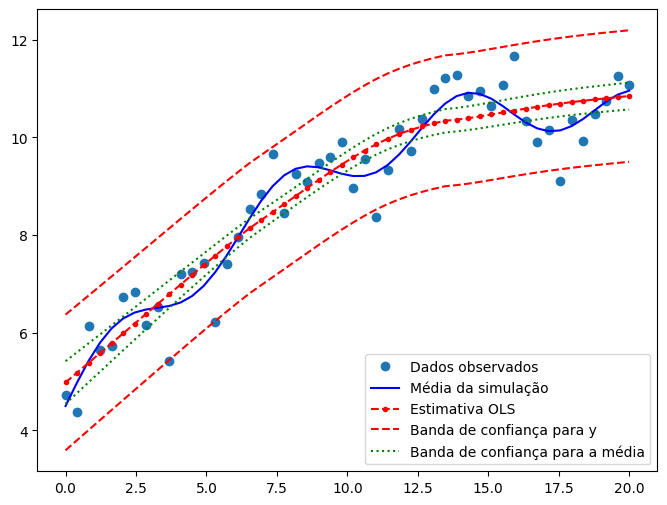

In [43]:
res = smf.ols('y ~ X1_lowess',data=df).fit()

print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs()

res.summary()

## Referências

- <a id='neter2005'></a> "Applied Linear Statistical Models" de Michael H Kutner, Christopher J. Nachtsheim, John Neter e William Li. Ed. McGraw-Hill Irwin, 2005.

- Regressão segmentada
    - Um artigo com uso de regressão segmentada [link](https://www.scielo.br/j/sa/a/J3mDJfyhJG9VMbfYWGGXwmt/?lang=pt&format=pdf)
    - Esta referência explica regressão segmentada em R. [link](http://www.leg.ufpr.br/~paulojus/CE092-2015/segmentada.html)

- Lowess
    - [Wikipedia](https://en.wikipedia.org/wiki/Local_regression)
    - [Towards Data Science](https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35)
    - [Help do statsmodels](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html)
    - [Cleveland, W.S. (1979) “Robust Locally Weighted Regression and Smoothing Scatterplots”. Journal of the American Statistical Association 74 (368): 829-836.](https://www.semanticscholar.org/paper/Robust-Locally-Weighted-Regression-and-Smoothing-Cleveland/30e7e25061b7ccd9a625548dd6836afcff85043b)